<img src="images/optimization.jpg" width = "250px" />

   # <center> Méthodes d'optimisation pour la régression logistique pénalisée lasso </center> 
------------------------------------
# Authors :
- Penda TOURE
- Mohamed NIANG
-----------------------------------

In [1]:
### Ignore warning
import warnings
warnings.filterwarnings("ignore")

### Print table of content
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Introduction

On veut comparer les algorithmes ISTA, FISTA, ADMM et SGD sur la régression logistique pénalisée lasso.

On considère que l'on observe les couples $(y_i,X_i)$ avec $y_i \in \{ -1, 1\}$ et $X_i \in \mathbb R^p$ dont la vraisemblance au point $\beta \in \mathbb R^p$ est donnée par :
$$
\prod_{i=1}^n \frac{1}{1+\exp(-y_i X_i \beta)}
$$

On veut donc résoudre :
$$
\arg\min_\beta \frac{1}{n}\sum_{i=1}^n \log\big(1 + \exp(-y_i X_i \beta) \big)+  \lambda\| \beta \|_{\ell_1}
$$

##  Nom du fichier de notre projet

In [2]:
# Change here using YOUR first and last names
fn1 = "Penda"
ln1 = "Toure"
fn2 = "Mohamed"
ln2 = "Niang"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp", fn1, ln1, "and", fn2, ln2])) + ".ipynb"
print(filename)

tp_penda_toure_and_mohamed_niang.ipynb


## Importation des packages

In [3]:
import time
import numpy as np
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy
import matplotlib.pylab as plt
%matplotlib inline

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

from numpy.random import binomial
from scipy.optimize import check_grad
from numpy.linalg import norm
from scipy import optimize
from math import sqrt, log

## Simulation dans un modèle logistique

### Choix des valeurs de $n$ et $p$

In [4]:
n_features = 50
n_samples = 2000

### Choix des valeurs des parametres $\beta^\star$

On pose $\beta^\star_j = (-1)^{j-1} \exp(-(j-1)/10)$.

Text(0.5, 1.0, 'Parameters')

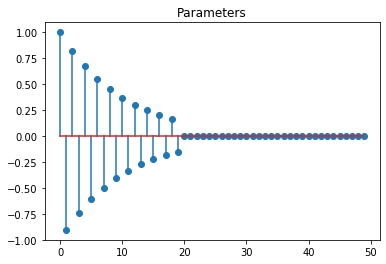

In [5]:
idx = np.arange(n_features)
params = (-1) ** idx  * np.exp(-idx / 10.)
params[20:] = 0.
plt.stem(params)
plt.title("Parameters")

### Simulation de la matrice X (features)

In [6]:
# Correlation
rho = 0.1

# Matrice de covariance Toeplitz
cov = toeplitz(rho ** np.arange(0, n_features))

# Simulation d'un vecteur gaussien de taille n avec cette matrice de covariance
features = multivariate_normal(np.zeros(n_features), cov, size=n_samples)

### Simulations des $y_i$

Coder une fonction **sigmoïd**. Attention aux overflows possibles !

In [7]:
def sigmoid(t):
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1 / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1 + exp_t)
    return out

Coder une fonction **simu_log_reg** qui pour $n$, $\beta^\star$ et $\rho$ renvoie une matrice de features et un vecteur de labels.

In [8]:
def simu_logreg(n_samples,params=params,rho=0.1):
    """ simulation in a logistic regression model 
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    n_samples : `int`, 
        Number of samples to simulate
    rho : `float`, default=0.1
        Correlation of the features
    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
    Simulated features matrix. It samples of a centered Gaussian
    vector with covariance given by the Toeplitz matrix
    y : `numpy.array`, shape=(n_samples,)
                 Simulated labels
    """
    n_features = params.size
    
    cov = toeplitz(rho ** np.arange(0, n_features))
    
    features = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    
    pis = sigmoid(features.dot(params))
    
    labels = 2 * ( binomial(1,pis, n_samples) - 1)
    
    return((features,labels))

In [9]:
X,y = simu_logreg(2000)

In [10]:
print(y.shape)
print(X.shape)

(2000,)
(2000, 50)


## Objectif, gradient sans lasso (quand $\lambda=0$)

- Coder une fonction qui calcule la perte logistique et son gradient pour une matrice de features $X$, un vecteur de labels $y$ et une valeur courante $w$ du paramètre.
- Vérifier qu'il n'y pas d'erreur en utilisant la fonction **check_grad** de scipy.optimize.
- Coder une fonction qui calcule l'objectif.

In [11]:
def loss_logreg(w,X,y):
    """ calcul de la perte logistique
     Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    w : `numpy.array`, shape=(n_features,)
        value of the parameter
    """
    u = y * X.dot(w)
    return -np.mean(np.log(sigmoid(u)))

In [12]:
loss_logreg(np.zeros(n_features),X,y)

0.6931471805599454

In [13]:
def grad_logreg(w,X,y):
    """ calcul du gradient de la perte logistique
         Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    w : `numpy.array`, shape=(n_features,)
        value of the parameter
    """
    n_samples, _ = X.shape
    u = y * X.dot(w)
    return X.T.dot(y * (sigmoid(u) - 1)) / n_samples

In [14]:
grad_logreg(np.zeros(n_features),X,y)

array([-1.49e-01,  1.04e-01, -1.09e-01,  8.85e-02, -8.51e-02,  8.57e-02,
       -6.09e-02,  6.46e-02, -8.23e-02,  3.56e-02, -4.00e-02,  2.74e-02,
       -3.38e-02,  6.03e-02, -5.52e-02,  9.14e-03, -1.15e-02, -1.91e-02,
       -5.67e-03,  2.83e-02, -1.87e-02, -1.09e-02,  1.17e-02,  2.65e-03,
        1.41e-02,  3.59e-03,  8.48e-03,  1.21e-04, -4.53e-03, -1.99e-03,
       -2.45e-02, -3.82e-02, -6.06e-03, -3.53e-03,  1.30e-02, -2.37e-02,
        1.14e-02,  2.26e-02, -3.35e-02,  6.27e-03, -2.23e-02, -1.06e-02,
       -2.86e-02,  1.75e-02,  6.61e-03, -1.09e-02,  1.46e-02, -6.34e-04,
       -1.27e-02, -1.03e-02])

In [15]:
print('logistic gradient check: ', check_grad(loss_logreg, grad_logreg, params,X,y))

logistic gradient check:  3.023676982379518e-08


In [16]:
def objective(X,y,w):
    return(loss_logreg(X,y,w))

In [17]:
objective(np.zeros(n_features),X,y)

0.6931471805599454

On met le tout dans une classe comme indiqué ci-dessous

In [18]:
class Logreg:
    """       
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    lamb : `float`, 
        value of the regularization parameter
    """
    def __init__(self,X,y,lamb):
        self.X = X
        self.y = y
        self.lamb = lamb
        self.n_samples, self.n_features = X.shape

    def loss(self,w):
        u = self.y * self.X.dot(w) 
        return -np.sum(np.log(sigmoid(u))) / self.n_samples

    def grad(self,w):
        u = self.y * self.X.dot(w) 
        return self.X.T.dot(self.y  * (sigmoid(u) - 1)) / self.n_samples

    def objective(self,w):
        return(self.loss(w))

    def lip_const(self):
        return np.sum(norm(X,axis=0,ord=2)) / (4*n_samples)
    
    def hessian(self,w):
        u = self.y * self.X.dot(w)
        var = sigmoid(u)*(1-sigmoid(u))
        hessian = self.X.T.dot(np.diag(var)).dot(self.X)/self.n_samples
        return hessian

In [19]:
model_logreg = Logreg(X,y,0.1)

In [20]:
model_logreg.lip_const()

0.2801826768944102

In [21]:
gradian = model_logreg.grad(np.zeros(n_features))
gradian

array([-1.49e-01,  1.04e-01, -1.09e-01,  8.85e-02, -8.51e-02,  8.57e-02,
       -6.09e-02,  6.46e-02, -8.23e-02,  3.56e-02, -4.00e-02,  2.74e-02,
       -3.38e-02,  6.03e-02, -5.52e-02,  9.14e-03, -1.15e-02, -1.91e-02,
       -5.67e-03,  2.83e-02, -1.87e-02, -1.09e-02,  1.17e-02,  2.65e-03,
        1.41e-02,  3.59e-03,  8.48e-03,  1.21e-04, -4.53e-03, -1.99e-03,
       -2.45e-02, -3.82e-02, -6.06e-03, -3.53e-03,  1.30e-02, -2.37e-02,
        1.14e-02,  2.26e-02, -3.35e-02,  6.27e-03, -2.23e-02, -1.06e-02,
       -2.86e-02,  1.75e-02,  6.61e-03, -1.09e-02,  1.46e-02, -6.34e-04,
       -1.27e-02, -1.03e-02])

In [22]:
gradian.shape

(50,)

In [23]:
hessian = model_logreg.hessian(np.zeros(n_features))
hessian

array([[ 2.51e-01,  3.27e-02, -1.70e-03, ...,  2.97e-04, -5.37e-03,
         1.28e-04],
       [ 3.27e-02,  2.47e-01,  2.18e-02, ...,  3.80e-03,  8.54e-03,
         1.48e-03],
       [-1.70e-03,  2.18e-02,  2.42e-01, ...,  2.29e-03,  9.15e-04,
        -9.51e-03],
       ...,
       [ 2.97e-04,  3.80e-03,  2.29e-03, ...,  2.49e-01,  2.09e-02,
         1.89e-03],
       [-5.37e-03,  8.54e-03,  9.15e-04, ...,  2.09e-02,  2.35e-01,
         2.53e-02],
       [ 1.28e-04,  1.48e-03, -9.51e-03, ...,  1.89e-03,  2.53e-02,
         2.60e-01]])

In [24]:
hessian.shape

(50, 50)

In [25]:
model_logreg.lip_const()

0.2801826768944102

In [26]:
print(check_grad(model_logreg.loss, model_logreg.grad, params))

3.023676982379518e-08


## Descente de gradient et algorithme de Newton

- Coder l'algorithme de descente de gradient, il faut ajouter une méthode **lip_const** qui calcule une constante de Lipschitz pour le gradient.
- Coder l'algorithme de Newtow, il faudra ajouter une méthode **hessian** à la classe logreg.
- Représenter l'évolution des objectifs graphiquement.

### Descente de gradient

In [27]:
def gd(model, w0, step = None, n_iter=50, verbose=True):
    """
    Gradient descent
    """
    w = w0
    w_new = w0
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step==None:
            step = 1/model.lip_const()
            
        w_new[:] = w - step*model.grad(w)
        w[:] = w_new
        
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [28]:
w0 = np.zeros(n_features)

In [29]:
start = time.time()
w_gd , obj_gd = gd(model_logreg,w0)
end = time.time()
print(end - start)

Lauching GD solver...
   it    |   obj   
       0 | 5.57e-01
      10 | 5.42e-01
      20 | 5.42e-01
      30 | 5.42e-01
      40 | 5.42e-01
      50 | 5.42e-01
0.0648200511932373


### Algorithme de Newton

In [30]:
def newton(model, w0, step = None, n_iter=50, verbose=True):
    """
    Newton Raphson algorithm
    """
    w = w0
    w_new = w0
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.loss(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching NR solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step==None:
            step = 0.2
            
        hessian_inv = np.linalg.inv(model.hessian(w))
        w_new[:] = w - step*hessian_inv.dot(model.grad(w))
        w[:] = w_new
        
        obj = model.loss(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [31]:
start = time.time()
w0 = np.zeros(n_features)
w_newton, obj_newton = newton(model_logreg,w0)
end = time.time()
print(end - start)

Lauching NR solver...
   it    |   obj   
       0 | 6.19e-01
      10 | 5.44e-01
      20 | 5.42e-01
      30 | 5.42e-01
      40 | 5.42e-01
      50 | 5.42e-01
0.8776249885559082


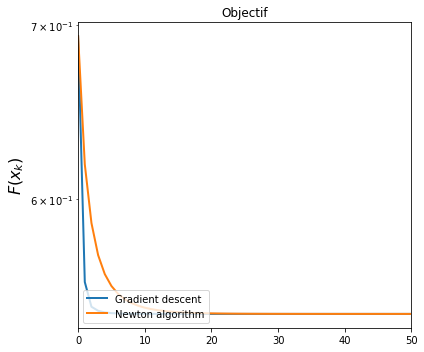

In [32]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_gd , label="Gradient descent", lw=2) 
plt.plot(obj_newton , label="Newton algorithm", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower left')
plt.title('Objectif')
n_iter = 50
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

## Proximal gradient descente (PGD)

On retourne au cas de la régression logistique pénalisée lasso.

- Faire une nouvelle classe **logreg_l1** sur le modèle de la classe **logreg** en ajoutant un méthode  qui calcule l'opérateur proximal de la norme 1 et en changeant la méthode objectif.

In [33]:
class Logregl1:
    """       
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples,n_features)
        features
    y : `numpy.array`, shape=(n_samples,)
        labels
    lamb : `float`, 
        value of the regularization parameter
    """
    def __init__(self,X,y,lamb):
        self.X = X
        self.y = y
        self.lamb = lamb
        self.n_samples, self.n_features = X.shape

    def loss(self,w):
        u = self.y * self.X.dot(w) 
        return -np.sum(np.log(sigmoid(u))) / self.n_samples

    def grad(self,w):
        u = self.y * self.X.dot(w) 
        return self.X.T.dot(self.y  * (sigmoid(u) - 1)) / self.n_samples
    
    def grad_i(self, i, w):
        x_i = X[i]
        y_i = y[i]
        lamb = 1. / (self.n_samples ** (0.5))
        return - x_i * y_i / (1. + np.exp(y_i * np.dot(x_i, w))) + lamb * w
        
    def lip_const(self):
        return np.sum(norm(X,axis=0,ord=2)) / (4*n_samples)
   
    def smoothness_lip_const(self,X):  
        return (np.linalg.norm(1/n_samples*X.T@X,ord=2))/4
    
    def pen(self,w,lamb):
        w = lamb*np.linalg.norm(w,ord = 1)
        return w
    
    def prox(self,w,lamb):
        z = np.sign(w)*np.maximum(np.abs(w)-lamb,0.)
        return z
  
    def objectivel1(self,w):
        return(self.loss(w) + self.pen(w,lamb))

In [34]:
X,y = simu_logreg(2000)

In [35]:
print(y.shape)
print(X.shape)

(2000,)
(2000, 50)


In [36]:
lamb=0
model_logregl1 = Logregl1(X,y,lamb)

In [37]:
print(check_grad(model_logregl1.objectivel1, model_logregl1.grad, params))

5.792110004208822e-08


Coder une fonction **pgd** qui code l'algorithme descente de gradient proximal (sur le modèle de la fonction **gd**).

In [38]:
def pgd(model, w0, step = None, lamb=0., n_iter=50, verbose=True):
    """
    Proximal gradient descent
    """
    w = w0
    w_new = w0
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.objectivel1(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step == None:
            step = 1 / (model.smoothness_lip_const(model.X))
    
        w_new[:] = model.prox(w - step*model.grad(w), step*lamb)
        w[:] = w_new

        obj = model.objectivel1(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.10e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [39]:
w0 = np.zeros(n_features)
w_pgd , obj_pgd = pgd(model_logregl1, w0, n_iter=50)

Lauching PGD solver...
   it    |   obj   
       0 | 5.7390227878e-01
      10 | 5.5959339061e-01
      20 | 5.5955314744e-01
      30 | 5.5955273925e-01
      40 | 5.5955273484e-01
      50 | 5.5955273479e-01


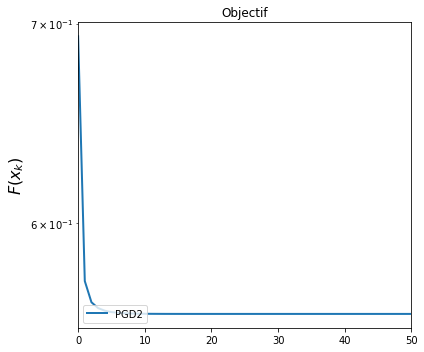

In [40]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_pgd , label="PGD2", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower left')
plt.title('Objectif')
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

Coder un arrêt prematuré quand $tol = 1e-02 > \|w_{\text{new}} - w\|/\|w\|$

In [41]:
def pgd2(model, w0, step = None, lamb=0., n_iter=50, verbose=True, tol=1e-02):
    """
    Proximal gradient descent
    """
    
    w = w0
    w_new = w0
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.objectivel1(w) 
    objectives.append(obj) 
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        if step == None:
            step = 1 / (10*model.smoothness_lip_const(model.X))
    
        w_new[:] = model.prox(w - step*model.grad(w), step*lamb)
        w[:] = w_new
        
        wu = w - model.prox(w - step*model.grad(w), step*lamb)
        
        obj = model.objectivel1(w) 
        objectives.append(obj)
        
        stop = norm(wu) / norm(model.prox(w - step*model.grad(w), step*lamb))
        
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.10e" % obj).rjust(8)]))
        
        if tol > stop:
            break
        
    return w, np.array(objectives)

In [42]:
lamb=0
model_logregl2 = Logregl1(X,y,lamb)

In [43]:
w0 = np.zeros(n_features)
w_pgd2 , obj_pgd2 = pgd2(model_logregl2, w0)

Lauching PGD solver...
   it    |   obj   
       0 | 6.6941264608e-01
      10 | 5.8874452442e-01
      20 | 5.7217472903e-01
      30 | 5.6600841827e-01


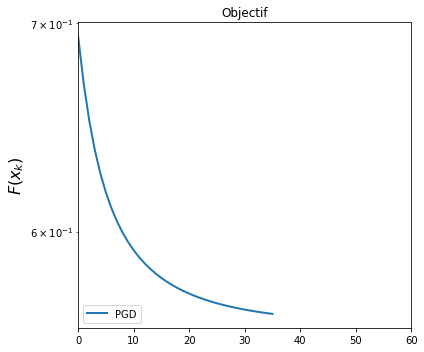

In [44]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_pgd2 , label="PGD", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower left')
plt.title('Objectif')
n_iter=60
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

## Stochastique proximal gradient descente  (SPGD)

- Coder un algorithme de descente de gradient stochastique proximal pour ce problème
- Comparer ses performances au PGD classique

In [45]:
def spgd(model, w0, step = 1., lamb=0., n_iter=50, verbose=True):
    """
    Stochastic Proximal gradient descent
    """
    w = w0
    w_new = w0
    n_samples, n_features = model.X.shape
    # objective history
    objectives = []
    # Current objective
    obj = model.objectivel1(w) 
    objectives.append(obj) 
    
    ind = np.random.randint(0, n_samples, n_samples * n_iter)
    
    if verbose:
        print("Lauching SPGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for k in range(n_iter + 1):
        i = ind[k]
    
        w_new[:] = model.prox(w - (step /(np.sqrt(k+1)))*model.grad_i(i,w), (step /(np.sqrt(k+1)))*lamb)
        w[:] = w_new

        obj = model.objectivel1(w) 
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.10e" % obj).rjust(8)]))
    return w, np.array(objectives)

In [46]:
w0 = np.zeros(n_features)
w_spgd , obj_spgd = spgd(model_logregl1, w0, step=0.01, n_iter=50)

Lauching SPGD solver...
   it    |   obj   
       0 | 6.9314718056e-01
      10 | 6.8962202497e-01
      20 | 6.8913466192e-01
      30 | 6.8722800320e-01
      40 | 6.8614515557e-01
      50 | 6.8538803124e-01


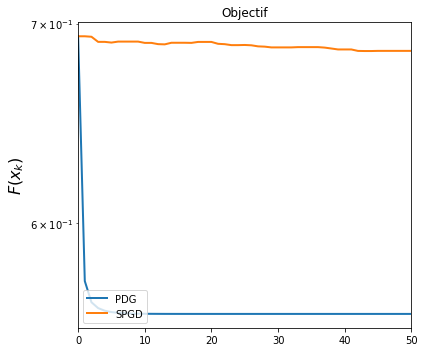

In [47]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_pgd , label="PDG", lw=2) 
plt.plot(obj_spgd , label="SPGD", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower left')
plt.title('Objectif')
n_iter = 50
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')

## Alternating direction method of multipliers (ADMM)

- Coder un algorithme ADMM pour ce problème
- Comparer ses performances au PGD classique et au SPGD

In [48]:
def Sthresh(x, gamma):
    return np.sign(x)*np.maximum(0, np.absolute(x)-gamma/2.0)

In [49]:
def admm(A, y, verbose=True):

    m, n = A.shape
    w, v = np.linalg.eig(A.T.dot(A))
    n_iter = 50

    "Function to caluculate min 1/2(y - Ax) + l||x||"
    "via alternating direction methods"
    xhat = np.zeros([n, 1])
    zhat = np.zeros([n, 1])
    u = np.zeros([n, 1])

    "Calculate regression co-efficient and stepsize"
    l = sqrt(2*log(n, 10))
    rho = 1/(np.amax(np.absolute(w)))

    "Pre-compute to save some multiplications"
    AtA = A.T.dot(A)
    Aty = A.T.dot(y)
    Q = AtA + rho*np.identity(n)
    Q = np.linalg.inv(Q)

    
    if verbose:
        print("Lauching ADMM solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]])) 
    for i in range(n_iter + 1):

        "x minimisation step via posterier OLS"
        xhat = Q.dot(Aty + rho*(zhat - u))

        "z minimisation via soft-thresholding"
        zhat = Sthresh(xhat + u, l/rho)

        "mulitplier update"
        u = u + xhat - zhat
        
        if i % 10 == 0 and verbose:
            print(' | '.join([("%d" % i).rjust(8), ("%.10e" % rho).rjust(8)]))
    return np.array(zhat), rho, l

In [50]:
A = np.random.randn(n_samples, n_features)

num_non_zeros = 19
positions = np.random.randint(0, n_features, num_non_zeros)
amplitudes = 100*np.random.randn(num_non_zeros, 1)
w0 = np.zeros((n_features, 1))
w0[positions] = amplitudes

y = A.dot(w0) + np.random.randn(n_samples, 1)

xhat, rho, l = admm(A, y)

Lauching ADMM solver...
   it    |   obj   
       0 | 3.6904563564e-04
      10 | 3.6904563564e-04
      20 | 3.6904563564e-04
      30 | 3.6904563564e-04
      40 | 3.6904563564e-04
      50 | 3.6904563564e-04


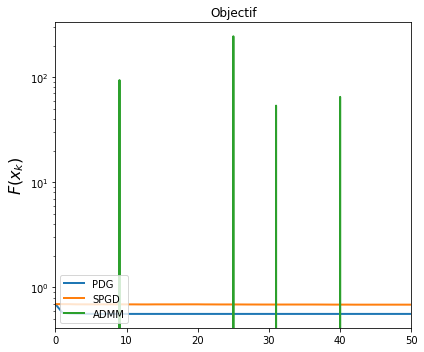

In [51]:
plt.figure(figsize=(6, 5))
plt.yscale("log")
plt.plot(obj_pgd , label="PDG", lw=2) 
plt.plot(obj_spgd , label="SPGD", lw=2) 
plt.plot(xhat , label="ADMM", lw=2) 
#plt.plot(obj_agd - obj_opt, label="AGD", lw=2) 
#plt.plot(obj_cd - obj_opt, label="CD", lw=2) 
#plt.plot(obj_cgd - obj_opt, label="CGD", lw=2) plt.xlabel(r"$k$", fontsize=16)
plt.ylabel(r"$F(x_k)$", fontsize=16) 
plt.legend(loc='lower left')
plt.title('Objectif')
n_iter = 50
plt.xlim((0, n_iter))
plt.tight_layout()
#plt.savefig('gd_agd_cgd.pdf')